In [402]:
import cloudpickle as pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mapie.risk_control import BinaryClassificationController, BinaryClassificationRisk

In [403]:

# import model
with open('../models/cal_rf.pkl', 'rb') as f:
  model = pickle.load(f)
  
# import data
X_cal = pd.read_csv('../data/partitions/X_cal.csv')
y_cal = pd.read_csv('../data/partitions/y_cal.csv')
X_test = pd.read_csv('../data/partitions/X_test.csv')
y_test = pd.read_csv('../data/partitions/y_test.csv')

In [404]:
# send to human if score is between the lambdas
def send_to_human(X, lambda_1, lambda_2):
    y_score = model.predict_proba(X)[:, 1]
    return (lambda_1 <= y_score) & (y_score < lambda_2)

In [405]:
# lambda values to explore
to_explore = []
for i in range(9):
    lambda_1 = i / 10
    for j in range(i + 1, 10):
        lambda_2 = j / 10
        if lambda_2 > 0.99:
            break
        to_explore.append((lambda_1, lambda_2))
to_explore = np.array(to_explore)

In [406]:
prop_positive = BinaryClassificationRisk(
    risk_occurrence=lambda y_true, y_pred: y_pred,
    risk_condition=lambda y_true, y_pred: True,
    higher_is_better=False,
)

In [407]:
target_level = 0.08
confidence_level = 0.9

bcc = BinaryClassificationController(
    predict_function=send_to_human,
    risk=prop_positive,
    target_level=target_level,
    confidence_level=confidence_level,
    best_predict_param_choice="recall",
    list_predict_params=to_explore,
)
bcc.calibrate(X_cal, y_cal)

In [408]:
print(
    f"{len(bcc.valid_predict_params)} multi-dimensional parameters "
    f"found that guarantee\n"
    f"of at most {target_level*100}% of cases get sent to a human with a confidence of {confidence_level*100}%."
)

21 multi-dimensional parameters found that guarantee
of at most 8.0% of cases get sent to a human with a confidence of 90.0%.


Interpretation: With 90% confidence, no more than 8% of future Alzheimer's cases will be sent to a human for review.

In [409]:
# Best lambda values
bcc.best_predict_param

(0.3, 0.8)

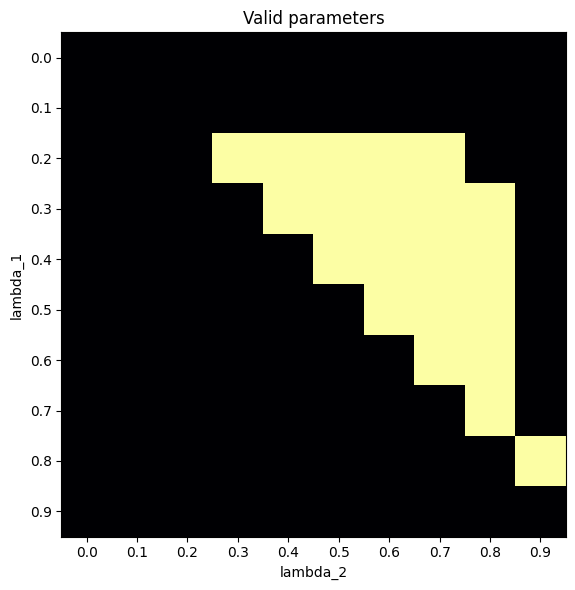

In [410]:
matrix = np.zeros((10, 10))
for valid_params in bcc.valid_predict_params:
    row = valid_params[0] * 10
    col = valid_params[1] * 10
    matrix[int(row), int(col)] = 1

fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(matrix, cmap="inferno")
ax.set_xticks(range(10), labels=(np.array(range(10)) / 10))
ax.set_yticks(range(10), labels=(np.array(range(10)) / 10))
ax.set_xlabel(r"lambda_2")
ax.set_ylabel(r"lambda_1")
ax.set_title("Valid parameters")
fig.tight_layout()
plt.show()

In [411]:
lambda_1, lambda_2 = bcc.best_predict_param
pred_prob = model.predict_proba(X_test)[:, 1]
should_send = bcc.predict(X_test)
pred = model.predict(X_test)

# tests if the model predicts correctly out of the send to human range. returns true if so, returns false if not
def test():
  for i in range(len(X_test)):
      if should_send[i]:
          if pred_prob[i] < lambda_1:
            if pred[i] == 1:
              return False
          elif pred_prob[i] >= lambda_2:
            if pred[i] == 0:
              return False
  return True

test()

True

The code here is from MAPIE docs

In [412]:
# export model
with open('../models/bcc_rf.pkl', 'wb') as f:
  pickle.dump(bcc, f)